# Finding the Rotation Curve of an Asteroid or Comet with TESScut and lightkurve
---

## Learning Goals

By the end of this tutorial, you will:
- Understand what a cutout of SOMETHING SOMETHING is?
- Use the TESScut API to find a cutout of an asteroid or comet by name.
- Plot the lightcurve using lightkurve
- Find the rotation period of the asteroid using lightkurve

## Introduction
Intro ideas...
- Asteroids and comets and moving targets, they won't have a fixed RA and Dec. But built-in tools can be searched by object name or ID understood by [JPL Horizon ephemerades interface](https://ssd.jpl.nasa.gov/horizons/app.html#/)
- "While its primary mission avoids the vicinity of the ecliptic plane by approximately six degrees, the scale height of the solar system debris disk is large enough to place various small body populations in the field of view." https://ui.adsabs.harvard.edu/abs/2020ApJS..247...26P/abstract <- They have MAST data (TSSYS-DR1) and published lightcurves and periods. We'll get the TESS cutout by object name and compare.
- What is a CUTOUT, what is an FFI TIME SERIES. FFI = full-frame images, as opposed to target pixel files (TPFs) https://heasarc.gsfc.nasa.gov/docs/tess/data-products.html 

The workflow for this notebook consists of:
    THE TOC

## Imports

- *numpy* to handle array functions
- *astropy.io fits* for acccessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data

JRK be sure to review when done-ish.

In [105]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Mast
from astroquery.mast import Observations

# JRK be sure to review when done-ish.

import requests
from astroquery.mast import Tesscut
import lightkurve as lk

## Searching the TESS archive by target name using the TESScut API

You can duse the [TESScut webpage](https://mast.stsci.edu/tesscut/) to make a cutout of a TESS FFI time series; for a solar system object like an asteroid or comet, be sure to click on the "Moving Target" button at the top after the words "Create cutout based on." 

To create a scriptable process for using TESScut, we can instead use the API or Application Programming Interface. We can use a script to create a unique URL that contains the same information and settings you'd input by hand on the webpage. Then we can use the python `requests` library to access that URL and deliver the results into this notebook.

The URLs for the TESScut API will all start with `https://mast.stsci.edu/tesscut/api/v0.1/` and for the case of moving targets, `moving_target/` will be appended. After `astrocut?` we will include all of the keywords we want separated by `&` signs. 
- `obj_id=hippodamia` to search by the object's name
- `x=4` for our cutout image to be 4 pixels in width
- `y=4` for our cutout image to be 4 pixels in height.

1 TESS pixel is about 21 arcseconds wide. 

JRK justify the width and height based on something useful.

Below, we print the status code from our query; a code of 200 means success. 

In [41]:
objname='hippodamia'

In [2]:
url='https://mast.stsci.edu/tesscut/api/v0.1/moving_target/astrocut?obj_id='+objname+'&x=4&y=4'
r=requests.get(url)
r.status_code

200

In [ ]:
#r.json().keys() # THIS BREAKS IT

## Searching the TESS archive by target name using astroquery

Built-in [MAST functionality in astroquery can also access TESScut](https://astroquery.readthedocs.io/en/latest/mast/mast.html#cutouts). 

TESS observed distinct areas of the sky called Sectors. We can use `Tesscut.get_sectors` to see which sectors inlude observations of our object. Whenever using Tesscut with a moving target, we must always set `moving_target=True` (the default is `False`). 

In [42]:
sector_table=Tesscut.get_sectors(objectname=objname, moving_target=True)
print(sector_table)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0003-1-2      3      1   2


Next we'll use `Tess.get_cutouts` to You can specify `sector=3` when requesting the cutouts, but it's not necessary. Without specifying the sector, we will receive results for all sectors available. 

JRK is that true or did I make it up. 

JRK if I chose one with multiple sectors observed, would hdulist be longer than 1? Tried with Ceres, takes forever, gave up.

In [43]:
hdulist = Tesscut.get_cutouts(objectname=objname, moving_target=True, size=5)

In [44]:
print('Length of hdulist =',len(hdulist))
hdulist[0].info()

Length of hdulist = 1
Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  PIXELS        1 BinTableHDU    150   1267R x 16C   [D, E, J, 25J, 25E, 25E, 25E, 25E, J, E, E, 38A, D, D, D, D]   
  2  APERTURE      1 ImageHDU        97   (2136, 2078)   int32   


The result that we get is describe in the [astrocut documentation on Path Focused Target Pixel Files](https://astrocut.readthedocs.io/en/latest/astrocut/file_formats.html#path-focused-target-pixel-files). Extension 0 is the header with metadata. Astronomers not used to working with moving targets may note that the `RA_OBJ` and `DEC_OBJ` keywords are not there!

Extension 1 is the data we most want in the form of a binary table; we'll look at tha tnext.

But first, extension 2, if present, is an image the size of the full image that the cutouts were drawn from. It's an array of 1's if the pixel was used and 0 if the pixel was not. By displaying this array as an image, we can see the trajectory of our moving target through the TESS sector. 

JRK is that right, is it the whole sector or some subset? 

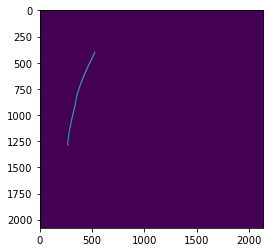

In [45]:
plt.imshow(hdulist[0][2].data)

Going back to Extension 1, this is a binary table with 1267 rows and 16 columns. The header keys `TTYPE1`, `TTYPE2`, etc. tell us the names of each column. Let's view each of them.

In [60]:
for i in range(1,17): print(i-1,hdulist[0][1].header['TTYPE'+str(i)])

0 TIME
1 TIMECORR
2 CADENCENO
3 RAW_CNTS
4 FLUX
5 FLUX_ERR
6 FLUX_BKG
7 FLUX_BKG_ERR
8 QUALITY
9 POS_CORR1
10 POS_CORR2
11 FFI_FILE
12 TGT_X
13 TGT_Y
14 TGT_RA
15 TGT_DEC


Examining the first row of this binary table, we can see that some of the columns are really arrays; these are the single cutout images we requested. 

In [59]:
print(hdulist[0][1].data[0])

(1382.0576094717571, 0.004970673, 0, array([[-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]], dtype=int32), array([[145.30815, 145.67703, 147.01529, 148.26833, 146.83429],
       [147.08664, 155.12308, 187.63747, 179.78893, 153.01134],
       [152.07637, 168.54951, 230.23271, 240.85228, 162.49188],
       [147.38747, 156.7292 , 176.37457, 179.8293 , 151.83972],
       [145.20474, 146.8089 , 151.55435, 152.69827, 147.08081]],
      dtype=float32), array([[0.36228755, 0.36212125, 0.36649147, 0.36717445, 0.36338165],
       [0.36321196, 0.37023285, 0.4006252 , 0.39401156, 0.3682797 ],
       [0.36974123, 0.3842766 , 0.4421701 , 0.44933993, 0.37955892],
       [0.3637108 , 0.37181395, 0.39431497, 0.39451766, 0.37103018],
       [0.36040527, 0.36415857, 0.36874247, 0.36804777, 0.3647822 ]],
      dtype=float32), array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
     

The column of index i=4 is the array of fluxes; it's exactly the size we requested. Let's view the first cutout!

RA:  28.747652131598336
Dec:  -18.551440349900805


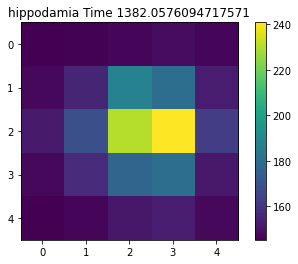

In [103]:
fig,ax=plt.subplots(1,1)
imgplot=plt.imshow(hdulist[0][1].data[0][4])
plt.colorbar()
ax.set_title(objname+' Time '+str(hdulist[0][1].data[0][0]))
print('RA: ',hdulist[0][1].data[0][14])
print('Dec: ',hdulist[0][1].data[0][15])

Let's view another cutout at a later time, say at row 500.

RA:  26.787163993772285
Dec:  -19.15745493486343


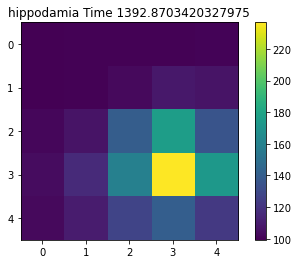

In [124]:
i=500
fig,ax=plt.subplots(1,1)
imgplot=plt.imshow(hdulist[0][1].data[i][4])
plt.colorbar()
ax.set_title(objname+' Time '+str(hdulist[0][1].data[i][0]))
print('RA: ',hdulist[0][1].data[i][14])
print('Dec: ',hdulist[0][1].data[i][15])

At this later time, the target has moved to a different RA and Dec, and also appears differently due to its rotation about its own axis.

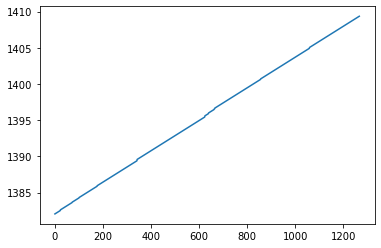

In [98]:
times=np.zeros(1267)
for i in range(0,1267): times[i]=hdulist[0][1].data[i][0]
plt.plot(times)

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  598 / length of dimension 1                          
NAXIS2  =                 1267 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   16 / number of table fields                         
TTYPE1  = 'TIME    '           / column name                                    
TDISP1  = 'D14.7   '           / display format                                 
TUNIT1  = 'BJD - 2457000, days' / unit                                          
TFORM1  = 'D       '           / column format                                  
TTYPE2  = 'TIMECORR'        

# Attempt to get this into lightkurve

In [137]:
hdulist[0].writeto('testfile.fits')

In [138]:
tpf = lk.TessTargetPixelFile('testfile.fits')

In [139]:
tpf.interact()

In [140]:
lc=tpf.to_lightcurve()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

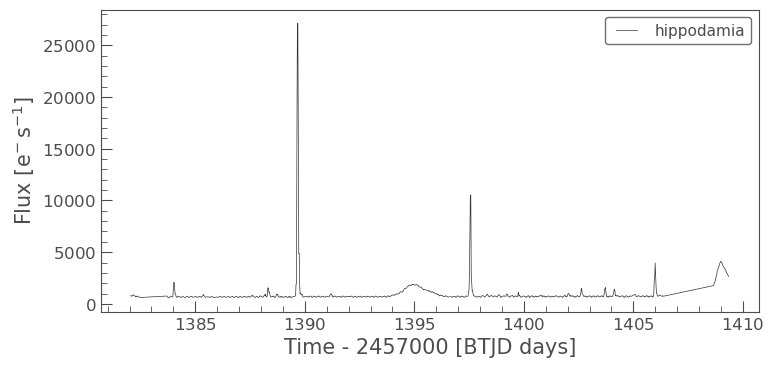

In [141]:
lc.plot()

In [142]:
pg=lc.to_periodogram()

<AxesSubplot:xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power [$\\mathrm{\\frac{e^{-}}{s}}$]'>

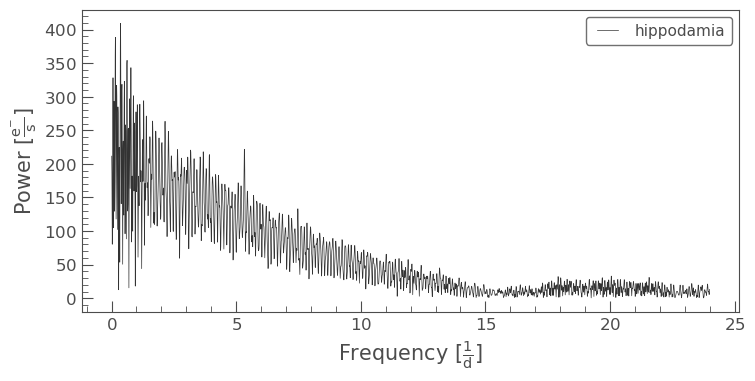

In [143]:
pg.plot()

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

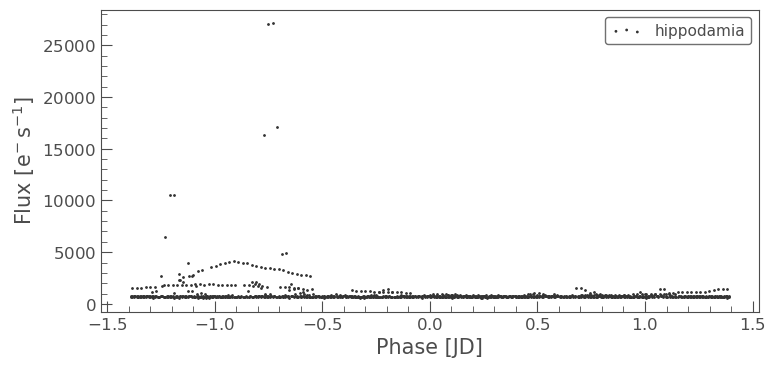

In [144]:
lc.fold(period=pg.period_at_max_power).scatter()

# Playing around with a non-moving target in lightkurve

Though `lightkurve` has a `search_tesscut` feature, it does not work for moving targets at the time of the writing of this tutorial. 

Just how different are these from targetpixelfiles? 

You can't do search_tesscut https://docs.lightkurve.org/reference/api/lightkurve.search_tesscut.html with moving_target=True, and you can't resolve by name to a sky position. But I'll investigate what you CAN do with a non-moving target? You get the list of dataproducts. 



In [117]:
search_result=lk.search_tesscut('WASP-12b')
print(search_result)

SearchResult containing 4 data products.

 #     mission     year  author exptime target_name distance
                                   s                 arcsec 
--- -------------- ---- ------- ------- ----------- --------
  0 TESS Sector 20 2019 TESScut    1426    WASP-12b      0.0
  1 TESS Sector 43 2021 TESScut     475    WASP-12b      0.0
  2 TESS Sector 44 2021 TESScut     475    WASP-12b      0.0
  3 TESS Sector 45 2021 TESScut     475    WASP-12b      0.0


In [119]:
tpf=lk.search_targetpixelfile('WASP-12b',sector=20).download()

/Users/julia/opt/anaconda3/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [125]:
tpf.flux.shape

(17633, 11, 11)

In [133]:
tpf.pipeline_mask

array([[False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False,  True,  True, False, False, False,
        False, False],
       [False, False, False, False,  True,  True,  True, False, False,
        False, False],
       [False, False, False, False,  True,  True,  True, False, False,
        False, False],
       [False, False, False, False,  True,  True,  True, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, Fal

<AxesSubplot:title={'center':'Target ID: 86396382, Cadence: 442835'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

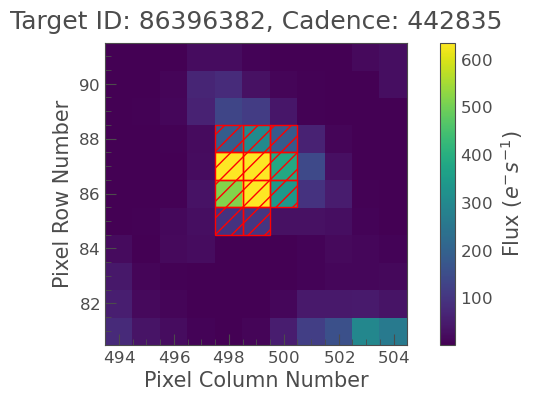

In [135]:
tpf.plot(frame=0,aperture_mask=tpf.pipeline_mask)

In [134]:
tpf.interact()

In [129]:
lc=tpf.to_lightcurve()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

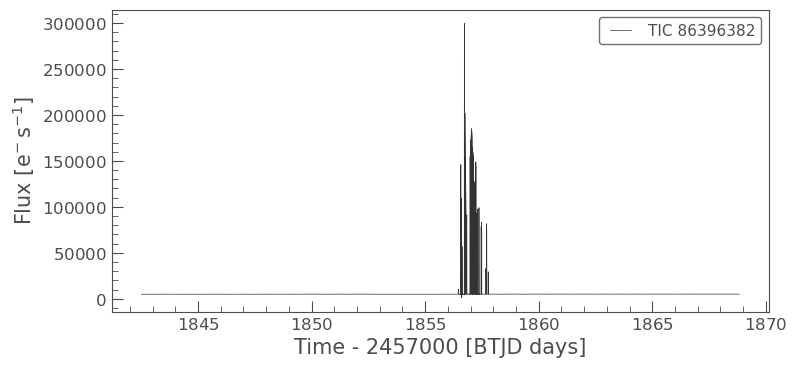

In [130]:
lc.plot()

## Exercises

## Additional Resources

## Citations

If you use `astropy` or `lightkurve` for published research, please cite the
authors. Follow these links for more information about citing `astropy` and
`lightkurve`:

TESScut citation https://ui.adsabs.harvard.edu/abs/2019ascl.soft05007B/abstract Brasseur et al. 2019

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)

## About this Notebook

**Author:** Julia Kamenetzky, ScienceBetter Consultant  
**Keywords:**   
**Last Updated:**  
**Next Review:**  

JRK not done, and add the footer.